In [1]:
import pickle
import pandas as pd
import os

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import wandb
from torch.utils.data.sampler import SubsetRandomSampler
import pprint
import matplotlib.pyplot as plt
import torch

from sklearn.preprocessing import MinMaxScaler
import math
from torch.profiler import profile, record_function, ProfilerActivity

from operator import itemgetter
import operator
from random import randint
from rnn_classes import Dog, DogInput, Race, Races, GRUNet, smallGRUNet, smalll_lin_GRUNet, smalll_prelin_GRUNet, GRUNetv2
from raceDB import build_dataset, build_pred_dataset
import importlib
import datetime
from training_testing import validate_model, train_regular, train_log, train_super_batch, train_super_batch_KL, train_super_batch_L1, train_regular_L1,train_regular_one_hot, train_double_loss_regular
from model_saver import model_saver, model_saver_wandb
import temperature_scaling_raceDB_v6
import visualization
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence,pad_sequence, unpack_sequence, unpad_sequence

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


c:\Users\Nick\Documents\GitHub\grvmodel\Python\pytorch\New Model\LSTM


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
torch.set_default_tensor_type(torch.FloatTensor)

In [4]:
torch.__version__

'1.12.1'

In [5]:
def profit_loss(logits,onehots,prices):

    preds = F.softmax(logits, dim=1)
    win_profit = (prices-1)*onehots

    
    pass


In [6]:
def custom_l2(output, target):
    loss = torch.mean(abs(output-target), dim=1)
    return loss

In [7]:
def validation_CLE(x,y):
    loss_t = -torch.log(torch.exp(x)/torch.sum(torch.exp(x), dim=-1, keepdim=True))*y
    return loss_t

In [8]:
def compare_model_to_bf(model:GRUNet,raceDB:Races,example_ct):
    with torch.no_grad():
        sft_max = nn.Softmax(dim=-1)
        l_sftmax = nn.LogSoftmax(dim=-1)
        nnl_loss = nn.KLDivLoss(reduction='batchmean')
        full_test_races = raceDB.get_test_input(range(0,len(raceDB.test_race_ids)))
        full_test_races_w_prices = []
        excluded, included = 0,0
        for r in full_test_races:
            if 0 in r.prices or -1 in r.prices:
                excluded+=1
            else:
                full_test_races_w_prices.append(r)
                included+=1
        print(included,excluded)

        output = l_sftmax(model(full_test_races_w_prices))
        bf_prices = torch.log(torch.tensor([x.implied_prob for x in full_test_races_w_prices ]).to('cuda:0'))
        full_classes = torch.stack([x.classes for x in full_test_races_w_prices ])

        print()

        print(f"our loss = {nnl_loss(output,full_classes)}")
        print(f"their loss = {nnl_loss(bf_prices ,full_classes)}")
        wandb.log({"our loss":nnl_loss(output,full_classes), "their loss":nnl_loss(bf_prices ,full_classes)})

In [9]:
os.getcwd()
os.chdir(r"C:\Users\Nick\Documents\GitHub\grvmodel\Python\DATA")
#dog_stats_file = open( 'new gru input 2023-01.npy', 'rb')
hidden_size = 32
raceDB = build_dataset('gru_inputs_new2_pir_simple_NO_SP.npy', hidden_size ,state_filter=["NZ"], margin_type='boosted_sftmin')
raceDB.create_new_weights_v2()
#raceDB.adjust_weights({"Dapto":10, "Gunnedah":10})

['speed_avg_1', 'split_speed_avg_1', 'split_margin_avg_1', 'margin_avg_1', 'first_out_avg_1', 'post_change_avg_1', 'races_1', 'wins_1', 'weight_', 'min_time_', 'min_split_time_']
(1192161, 21)
(126312, 24)
Latest date = 2023-03-29 00:00:00
num_features_per_dog=14


  0%|          | 0/3551 [00:00<?, ?it/s]

c:\Users\Nick\.conda\envs\PYTORCH\lib\site-packages\tqdm\std.py:1195: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for obj in iterable:


  0%|          | 0/16728 [00:00<?, ?it/s]

c:\Users\Nick\.conda\envs\PYTORCH\lib\site-packages\tqdm\std.py:1195: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for obj in iterable:


thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
thorwing
number of races = 16728, number of unique dogs = 3551
0                (Auckland, 318.0)
1                (Auckland, 318.0)
2                (Auckland, 318.0)
3                (Auckland, 527.0)
4                (Auckland, 527.0)
                   ...            
16723    (Palmerston North, 457.0)
16724    (Palmerston North, 375.0)
16725    (Palmerston North, 375.0)
16726    (Palmerston North, 457.0)
16727    (Palmerston North, 457.0)
Length: 16728, dtype: object


In [10]:
input_size = raceDB.get_race_input([0,1])[0].full_input.shape[0]
model = GRUNetv2(84,32,num_layers=2)
prev_model_file = 'borg-voyager-383'

if prev_model_file!=None:
    model_name = prev_model_file
    model_loc = f"C:/Users/Nick/Documents/GitHub/grvmodel/Python/pytorch/New Model/savedmodel/{model_name}/{model_name}_1099.pt"
    model_data = torch.load(model_loc,map_location=torch.device('cuda:0'))
    raceDB.fill_hidden_states_dict_v2(hidden_dict=model_data['db'])
    model.load_state_dict(model_data['model_state_dict'])

  0%|          | 0/3551 [00:00<?, ?it/s]

Empty: 312552897 BOTANY THOMMO
Empty: 2105680102 AGBEZE
Empty: 236039147 SMASH BURTON
Empty: 156016921 PUZZLE TIN
Empty: 212745710 GRUNT
Empty: 246691950 SPRING MECHANIC
Empty: 141326626 KIWI GAL
Empty: 1633220003 CAWBOURNE COOL
Empty: 1994480012 BLOCKER
Empty: 269941814 EXPRESS EMPORIUM
Empty: 1748140010 BIGTIME CHAMP
Empty: 222091334 WAITERIMU RIPPER
Empty: 124886887 BIGTIME JACOB
Empty: 203248200 FROSTY BLAZE
Empty: 214449123 FEAR THE FUR
Empty: 214449120 ALENG
Empty: 212745230 LITTLE APPLE
Empty: 219044300 HEART SHAPED BOX
Empty: 184228722 MONSOON MALABAR
Empty: 286157215 OPAWA DELIGHT
Empty: 253088671 PLATINUM EARNER
Empty: 204415051 CHOO CHOO
Empty: 171126622 THRILLING KATIE
Empty: 1435640001 LITTLE MOO
Empty: 393648741 BIG TIME ROSE
Empty: 1997400008 AUDRETTE
Empty: 183877600 RAINY RIVER
Empty: 194834905 BIGTIME LOVIE
Empty: 1842180005 GURU SECRET
Empty: 109563209 KURIDRANI
Empty: 171138597 PODIUM PHOBIA
Empty: 256289123 DIGGER ACE
Empty: 122176873 JINJA BAILEY
Empty: 114394340 

RuntimeError: Error(s) in loading state_dict for GRUNetv2:
	size mismatch for batchnorm.weight: copying a param with shape torch.Size([84]) from checkpoint, the shape in current model is torch.Size([326]).
	size mismatch for batchnorm.bias: copying a param with shape torch.Size([84]) from checkpoint, the shape in current model is torch.Size([326]).
	size mismatch for batchnorm.running_mean: copying a param with shape torch.Size([84]) from checkpoint, the shape in current model is torch.Size([326]).
	size mismatch for batchnorm.running_var: copying a param with shape torch.Size([84]) from checkpoint, the shape in current model is torch.Size([326]).

In [ ]:
model = model.to(device)

In [ ]:
raceDB.to_cuda()

In [ ]:
date = datetime.datetime.strptime("2022-08-01", "%Y-%m-%d").date()
raceDB.create_test_split_date(date)

Train examples 13565, Test examples 3163


In [ ]:
raceDB.create_dogs_test_split_date()

  0%|          | 0/3551 [00:00<?, ?it/s]

In [ ]:
raceDB.attach_races_to_dog_inputv2()

  0%|          | 0/3551 [00:00<?, ?it/s]

In [ ]:
test_idx = range(0,len(raceDB.test_dog_ids))
packed_y = pack_sequence([torch.stack(n,0) for n in [[z.full_input.to('cuda:0') for z in inner] for inner in [x for x in raceDB.get_dog_test(test_idx)]]], enforce_sorted=False)

In [ ]:
dogs = [x for x in  raceDB.test_dogs.values()]  #[Dog]
dog_input = [inner for inner in [x for x in raceDB.get_dog_test(test_idx)]] #[[DogInput]]
model.eval()

X = packed_y
hidden_in = torch.stack([x.hidden for x in dogs]).transpose(0,1)
output,hidden = model(X,h=hidden_in)
hidden = hidden.transpose(0,1)

for i,dog in enumerate(dog_input):
        [setattr(obj, 'hidden_out', val) for obj, val in zip(dog,output[i])]

raceDB.margin_from_dog_to_race_v3(mode='test')

len_test = len(raceDB.test_race_ids)
test_idx = range(0,len_test)

race = raceDB.get_test_input(test_idx)

Xt = torch.stack([r.hidden_in for r in race]) #Input for FFNN
y = torch.stack([x.classes for x in race])

output = model(Xt, p1=False)

In [ ]:
data_2 = (Xt,y,output.detach()) 

In [ ]:
races_idx = range(0,len(raceDB.test_race_ids))
race = raceDB.get_test_input(races_idx)
X = race
y = torch.stack([x.classes for x in race])
data = (X,y)

In [ ]:
importlib.reload(temperature_scaling_raceDB_v6)

<module 'temperature_scaling_raceDB_v6' from 'c:\\Users\\Nick\\Documents\\GitHub\\grvmodel\\Python\\pytorch\\New Model\\LSTM\\temperature_scaling_raceDB_v6.py'>

In [ ]:
scaled_model = temperature_scaling_raceDB_v6.ModelWithTemperature(model)
scaled_model.set_temperature(data_2)

tensor([1, 2, 0,  ..., 7, 3, 4], device='cuda:0')
Before temperature - NLL: 1.711, ECE: 0.021
tensor([1, 2, 0,  ..., 7, 3, 4], device='cuda:0')
Optimal temperature: 1.054
After temperature - NLL: 1.710, ECE: 0.022


ModelWithTemperature(
  (model): GRUNetv2(
    (gru): GRU(84, 32, num_layers=2)
    (batchnorm): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (fc0): Linear(in_features=32, out_features=1, bias=True)
    (rl1): ReLU()
    (drop1): Dropout(p=0.3, inplace=False)
    (fc1): Linear(in_features=326, out_features=64, bias=True)
    (rl2): ReLU()
    (drop2): Dropout(p=0.3, inplace=False)
    (fc2): Linear(in_features=64, out_features=8, bias=True)
    (output_fn): Identity()
  )
)

In [36]:
input, labels = data
logits = model(input)

In [21]:
_,labels1 = torch.max(y,1)

In [43]:
labels1

tensor([5, 5, 3,  ..., 0, 2, 7], device='cuda:0')

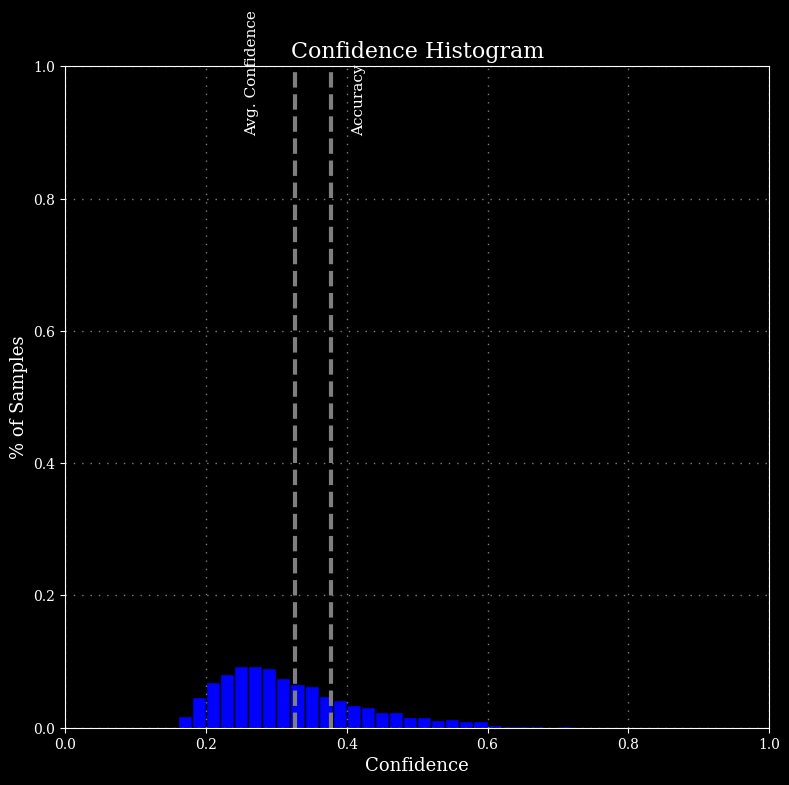

In [55]:
importlib.reload(visualization)

conf_hist = visualization.ConfidenceHistogram()
plt_test = conf_hist.plot(output.detach().to('cpu'),labels1.detach().to('cpu').numpy(),title="Confidence Histogram", n_bins=50)
plt_test.savefig('conf_histogram_test.png',bbox_inches='tight')

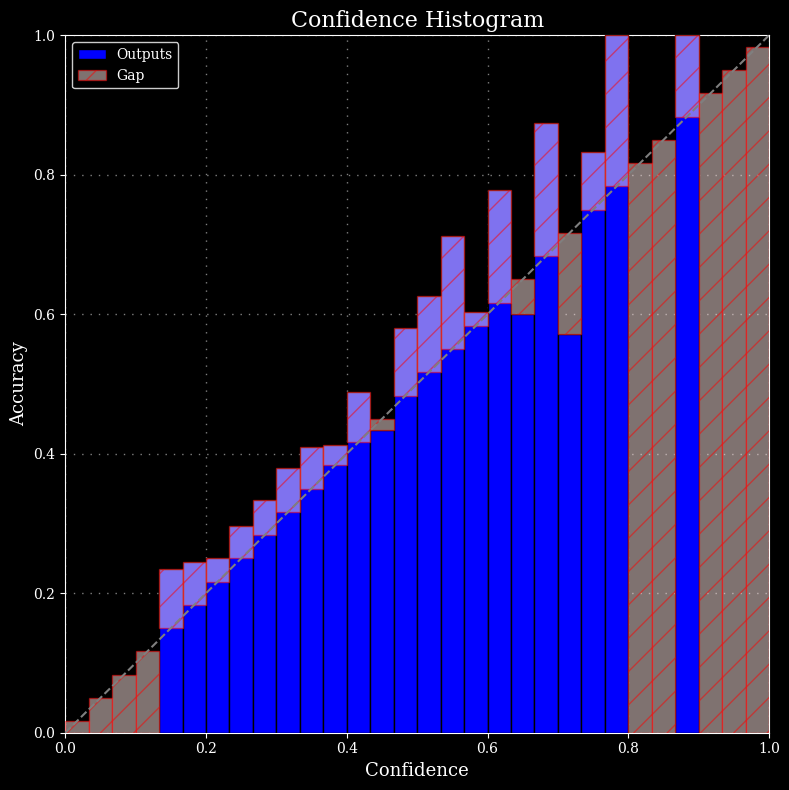

In [54]:
# import visualization

rel_diagram = visualization.ReliabilityDiagram()
plt_test_2 = rel_diagram.plot(output.detach().to('cpu'),labels1.detach().to('cpu').numpy(),title="Confidence Histogram", n_bins=30)
plt_test.savefig('conf_histogram_test.png',bbox_inches='tight')

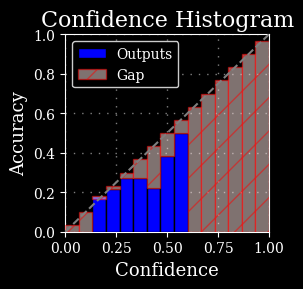

In [55]:
import visualization

rel_diagram = visualization.ReliabilityDiagram()
plt_test_2 = rel_diagram.plot(logits.detach().to('cpu').numpy()/1.835,labels1.detach().to('cpu').numpy(),title="Confidence Histogram")
plt_test.savefig('conf_histogram_test.png',bbox_inches='tight')

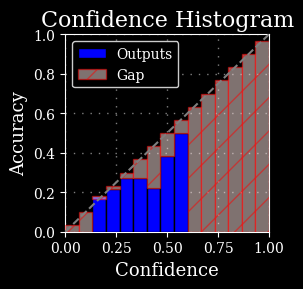

In [54]:
import visualization

rel_diagram = visualization.ReliabilityDiagram()
plt_test_2 = rel_diagram.plot(scaled_model.temperature_scale(logits).detach().to('cpu').numpy(),labels1.detach().to('cpu').numpy(),title="Confidence Histogram")
plt_test.savefig('conf_histogram_test.png',bbox_inches='tight')

In [11]:
#Testing
def predict_model(model,predDB):
    torch.autograd.set_detect_anomaly(True)
    list_t = [] 
    last = 0
    loss_val = 0 
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():

        races_idx = range(0,len(predDB.raceIDs)-1)
        race = predDB.get_race_input(races_idx)
        X = race
        # for i,r in enumerate(race):
        #     print(r.raceid, r.track_name)
        #     #print(i,r.lstm_input())

        output = model(X)
        
        print(output)

        _, predicted = torch.max(output.data, 1)

        for i,r in enumerate(race):
            print(r.raceid, r.track_name, r.dogs[predicted[i].item()])

        print(predicted)



In [12]:
def closure(optimizer, criterion, outs, classes):
    optimizer.zero_grad()
    loss = nn.functional.mse_loss(outs, classes)
    loss.backward()
    return loss

def model_pipeline(my_dataset=raceDB,config=None,prev_model=None, sweep=True, model_state_dict=None, prev_model_file=None):
    if my_dataset:
      dataset = my_dataset    
    else:
      dataset = raceDB
    # tell wandb to get started
    with wandb.init(project="GRU - FastTrack - AUS Testing", config=config):
      #  access all HPs through wandb.config, so logging matches execution!
      wandb.define_metric("loss", summary="min")
      wandb.define_metric("test_accuracy", summary="max")
      wandb.define_metric("bfprofit", summary="max")
      wandb.define_metric("multibet profit", summary="max")
      
      config = wandb.config
      pprint.pprint(config)
      pprint.pprint(config.epochs)
      print(config)
      input_size = raceDB.get_race_input([0,1])[0].full_input.shape[0] #create fix so messy

      model = smalll_prelin_GRUNet(input_size,config['hidden_size'])
      if model_state_dict:
        model.load_state_dict(model_state_dict)
      if prev_model_file!=None:
        model_name = prev_model_file
        model_loc = f"C:/Users/Nick/Documents/GitHub/grvmodel/Python/pytorch/New Model/savedmodel/{model_name}/{model_name}_450.pt"
        model_data = torch.load(model_loc,map_location=torch.device('cuda:0'))
        raceDB.fill_hidden_states_from_dict(hidden_dict=model_data['db'])
        model.load_state_dict(model_data['model_state_dict'])
        config['parent model'] = prev_model_file

      raceDB.to_cuda()

      criterion = nn.CrossEntropyLoss(reduction='none')
      #criterion = nn.SmoothL1Loss(reduction='none', beta=0.1)
      optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
      # optimizer = optim.Adadelta(model.parameters())
      # optimizer = optim.RMSprop(model.parameters(), lr=config['learning_rate'])
      # optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])
      # optimizer = optim.ASGD(model.parameters(), lr=config['learning_rate'])

      scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',threshold=0.0001, patience=10000, verbose=True, factor=0.5)
      model = model.to(device)
      # optimizer = optimizer.to(device)
      print(model)

      # and use them to train the model
      try:
        # train_double_loss_regular(model, dataset, criterion, optimizer, scheduler, config, crit2=custom_l2)
        train_regular(model, dataset, criterion, optimizer, scheduler, config)
      except KeyboardInterrupt:
        print("finished Early")
      dataset.create_hidden_states_dict()
      model_saver_wandb(model, optimizer, 450, 0.1, dataset.hidden_states_dict_gru, model_name="long nsw new  22000 RUN")
      if sweep:
        raceDB.reset_all_lstm_states()
    


    # and test its final performance
    #test(model, test_loader)

    return (model,dataset, optimizer)

In [13]:
len(raceDB.raceIDs)
wandb_config_static = {'hidden_size':hidden_size,'batch_size': 500, 'dropout': 0.3, 'epochs': 1000, 'f1_layer_size': 256, 'f2_layer_size': 64 , 'learning_rate': 0.000087, 'loss': 'L1', 'l1_beta':0.1,  'num_layers': 2, 'optimizer': 'adamW', 'validation_split': 0.1,'batch_before_backwards':7}

In [14]:
raceDB.reset_all_lstm_states()

In [14]:
#(model,dataset, optimizer) = model_pipeline(raceDB,config=wandb_config_static)
(model,dataset, optimizer) = model_pipeline(raceDB,config=wandb_config_static,sweep=False)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nickojelly (use `wandb login --relogin` to force relogin)


{'hidden_size': 64, 'batch_size': 500, 'dropout': 0.3, 'epochs': 1000, 'f1_layer_size': 256, 'f2_layer_size': 64, 'learning_rate': 8.7e-05, 'loss': 'L1', 'l1_beta': 0.1, 'num_layers': 2, 'optimizer': 'adamW', 'validation_split': 0.1, 'batch_before_backwards': 7}
1000
{'hidden_size': 64, 'batch_size': 500, 'dropout': 0.3, 'epochs': 1000, 'f1_layer_size': 256, 'f2_layer_size': 64, 'learning_rate': 8.7e-05, 'loss': 'L1', 'l1_beta': 0.1, 'num_layers': 2, 'optimizer': 'adamW', 'validation_split': 0.1, 'batch_before_backwards': 7}
smalll_prelin_GRUNet(
  (batchnorm): BatchNorm1d(510, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru1): GRUCell(510, 64)
  (gru2): GRUCell(510, 64)
  (gru3): GRUCell(510, 64)
  (gru4): GRUCell(510, 64)
  (gru5): GRUCell(510, 64)
  (gru6): GRUCell(510, 64)
  (gru7): GRUCell(510, 64)
  (gru8): GRUCell(510, 64)
  (rl1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (rl2): ReLU()
 

100%|██████████| 179/179 [02:49<00:00,  1.06it/s]6.23s/it]
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
 20%|█▉        | 197/1000 [25:04:37<102:13:02, 458.26s/it]


finished Early
created path



FK ROI,▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
FK ROI < 30,▄▆▆▇▇██▇▇▆▆▅▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▂▂▂▂▂
ROI,▁▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████
ROI < 30,▄▆▆▇▇██▇▇▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▂▂▂▂▂
accuracy,▁▁▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇▇▇▇████████████████████
batch_before_backwards,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,█████▇▃▇▇▇▇▇▆▆▆▆▆▆▆▂▆▅▆▅▆▅▅▅▅▅▅▅▁▅▄▅▅▅▄▄
correct,▁▁▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇▇▇▇████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_loss,█▇▇▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁
loss_val,█▇▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂


In [15]:
sweep_config = {"method": "random"}

metric = {"name": "ROI < 30", "goal": "maximize"}

sweep_config["metric"] = metric


parameters_dict = {
    "optimizer": {"value": "adamW"},
    "f1_layer_size": {"values": [256]},
    "f2_layer_size": {"values": [64]},
    "dropout": {"values": [0.3]},
    "len_data": {"value": len(raceDB.raceIDs)},
    "hidden_size": {"value":64}
}

sweep_config["parameters"] = parameters_dict

parameters_dict.update(
    {
        "epochs": {"values": [200]},
        "validation_split": {"value": 0.1},
        "loss": {
            "values": [ "CEL"],
            # "values": ["Huber", "MSE", "L1", "BCE", "Custom", "KL"]
            # 'value': 'l1_custom'
        },
        "num_layers": {"values": [2]},
    }
)

parameters_dict.update(
    {
        "learning_rate": {
            # a flat distribution between 0 and 0.1
            "distribution": "uniform",
            "min": 0.00001,
            "max": 0.001,
        },
        "l1_beta": {"value": 0.1
        },
        "batch_size": {
            'values': [250,500,1000]
        },
        "batch_before_backwards": {
            'values': [5,10,15,50]
        }
    }
)

import pprint

pprint.pprint(sweep_config)


sweep_config

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'ROI < 30'},
 'parameters': {'batch_before_backwards': {'values': [5, 10, 15, 50]},
                'batch_size': {'values': [250, 500, 1000]},
                'dropout': {'values': [0.3]},
                'epochs': {'values': [200]},
                'f1_layer_size': {'values': [256]},
                'f2_layer_size': {'values': [64]},
                'hidden_size': {'value': 64},
                'l1_beta': {'value': 0.1},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.001,
                                  'min': 1e-05},
                'len_data': {'value': 111168},
                'loss': {'values': ['CEL']},
                'num_layers': {'values': [2]},
                'optimizer': {'value': 'adamW'},
                'validation_split': {'value': 0.1}}}


{'method': 'random',
 'metric': {'name': 'ROI < 30', 'goal': 'maximize'},
 'parameters': {'optimizer': {'value': 'adamW'},
  'f1_layer_size': {'values': [256]},
  'f2_layer_size': {'values': [64]},
  'dropout': {'values': [0.3]},
  'len_data': {'value': 111168},
  'hidden_size': {'value': 64},
  'epochs': {'values': [200]},
  'validation_split': {'value': 0.1},
  'loss': {'values': ['CEL']},
  'num_layers': {'values': [2]},
  'learning_rate': {'distribution': 'uniform', 'min': 1e-05, 'max': 0.001},
  'l1_beta': {'value': 0.1},
  'batch_size': {'values': [250, 500, 1000]},
  'batch_before_backwards': {'values': [5, 10, 15, 50]}}}

In [16]:
sweep_id = wandb.sweep(sweep_config, project="gru_sweeps")
CUDA_LAUNCH_BLOCKING=1
wandb.agent(sweep_id, function=model_pipeline, count=100)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: mzjxl651
Sweep URL: https://wandb.ai/nickojelly/GRU_sweeps/sweeps/mzjxl651


wandb: Agent Starting Run: o4lw7zlw with config:
wandb: 	batch_before_backwards: 50
wandb: 	batch_size: 1000
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	f1_layer_size: 256
wandb: 	f2_layer_size: 64
wandb: 	hidden_size: 64
wandb: 	l1_beta: 0.1
wandb: 	learning_rate: 3.598900158654535e-05
wandb: 	len_data: 111168
wandb: 	loss: CEL
wandb: 	num_layers: 2
wandb: 	optimizer: adamW
wandb: 	validation_split: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nickojelly (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


{'batch_before_backwards': 50, 'batch_size': 1000, 'dropout': 0.3, 'epochs': 200, 'f1_layer_size': 256, 'f2_layer_size': 64, 'hidden_size': 64, 'l1_beta': 0.1, 'learning_rate': 3.598900158654535e-05, 'len_data': 111168, 'loss': 'CEL', 'num_layers': 2, 'optimizer': 'adamW', 'validation_split': 0.1}
200
{'batch_before_backwards': 50, 'batch_size': 1000, 'dropout': 0.3, 'epochs': 200, 'f1_layer_size': 256, 'f2_layer_size': 64, 'hidden_size': 64, 'l1_beta': 0.1, 'learning_rate': 3.598900158654535e-05, 'len_data': 111168, 'loss': 'CEL', 'num_layers': 2, 'optimizer': 'adamW', 'validation_split': 0.1}
smalll_prelin_GRUNet(
  (batchnorm): BatchNorm1d(510, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru1): GRUCell(510, 64)
  (gru2): GRUCell(510, 64)
  (gru3): GRUCell(510, 64)
  (gru4): GRUCell(510, 64)
  (gru5): GRUCell(510, 64)
  (gru6): GRUCell(510, 64)
  (gru7): GRUCell(510, 64)
  (gru8): GRUCell(510, 64)
  (rl1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (fc1)

100%|██████████| 200/200 [15:58:11<00:00, 287.46s/it]


created path



FK ROI,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
FK ROI < 30,▁▁▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████████
ROI,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
ROI < 30,▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
batch_before_backwards,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
correct,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_loss,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
loss_val,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 9onj9j75 with config:
wandb: 	batch_before_backwards: 5
wandb: 	batch_size: 1000
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	f1_layer_size: 256
wandb: 	f2_layer_size: 64
wandb: 	hidden_size: 64
wandb: 	l1_beta: 0.1
wandb: 	learning_rate: 0.0009297879614048912
wandb: 	len_data: 111168
wandb: 	loss: CEL
wandb: 	num_layers: 2
wandb: 	optimizer: adamW
wandb: 	validation_split: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


{'batch_before_backwards': 5, 'batch_size': 1000, 'dropout': 0.3, 'epochs': 200, 'f1_layer_size': 256, 'f2_layer_size': 64, 'hidden_size': 64, 'l1_beta': 0.1, 'learning_rate': 0.0009297879614048912, 'len_data': 111168, 'loss': 'CEL', 'num_layers': 2, 'optimizer': 'adamW', 'validation_split': 0.1}
200
{'batch_before_backwards': 5, 'batch_size': 1000, 'dropout': 0.3, 'epochs': 200, 'f1_layer_size': 256, 'f2_layer_size': 64, 'hidden_size': 64, 'l1_beta': 0.1, 'learning_rate': 0.0009297879614048912, 'len_data': 111168, 'loss': 'CEL', 'num_layers': 2, 'optimizer': 'adamW', 'validation_split': 0.1}
smalll_prelin_GRUNet(
  (batchnorm): BatchNorm1d(510, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru1): GRUCell(510, 64)
  (gru2): GRUCell(510, 64)
  (gru3): GRUCell(510, 64)
  (gru4): GRUCell(510, 64)
  (gru5): GRUCell(510, 64)
  (gru6): GRUCell(510, 64)
  (gru7): GRUCell(510, 64)
  (gru8): GRUCell(510, 64)
  (rl1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (fc1): 

100%|██████████| 200/200 [19:44:24<00:00, 355.32s/it]


created path



FK ROI,▁▂▄▃▄▄▄▅▅▅▆▇▇▇▇▇█▇▇▇▇▇██▇▇▇▇▇▇▇▇▇▇▆▆▇▆▆▇
FK ROI < 30,▄▅▆▃▂▂▂▂▃▁▂▄▃▃▅▄▆▅▅▄▂▆█▆▆▅▆▆▅▅▅▅▅▄▃▄▅▄▄▅
ROI,▁▂▃▃▃▄▄▅▅▅▅▇▇▆▇▇█▇▇▇▇▇██▇▇▇▇▆▇▆▇▇▆▆▆▆▆▆▆
ROI < 30,▄▅▅▂▂▂▂▂▃▁▂▄▃▃▅▅▆▅▅▅▃▆█▆▆▅▇▆▅▅▅▅▅▄▄▄▅▄▅▅
accuracy,▁▃▆▇██▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▆▆▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅
batch_before_backwards,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,██▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
correct,▁▃▆▇██▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▆▆▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_loss,██▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
loss_val,▃▃▁▁▁▁▁▂▂▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█▇███████


wandb: Agent Starting Run: lr2vc938 with config:
wandb: 	batch_before_backwards: 15
wandb: 	batch_size: 1000
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	f1_layer_size: 256
wandb: 	f2_layer_size: 64
wandb: 	hidden_size: 64
wandb: 	l1_beta: 0.1
wandb: 	learning_rate: 0.0005642941511686169
wandb: 	len_data: 111168
wandb: 	loss: CEL
wandb: 	num_layers: 2
wandb: 	optimizer: adamW
wandb: 	validation_split: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


{'batch_before_backwards': 15, 'batch_size': 1000, 'dropout': 0.3, 'epochs': 200, 'f1_layer_size': 256, 'f2_layer_size': 64, 'hidden_size': 64, 'l1_beta': 0.1, 'learning_rate': 0.0005642941511686169, 'len_data': 111168, 'loss': 'CEL', 'num_layers': 2, 'optimizer': 'adamW', 'validation_split': 0.1}
200
{'batch_before_backwards': 15, 'batch_size': 1000, 'dropout': 0.3, 'epochs': 200, 'f1_layer_size': 256, 'f2_layer_size': 64, 'hidden_size': 64, 'l1_beta': 0.1, 'learning_rate': 0.0005642941511686169, 'len_data': 111168, 'loss': 'CEL', 'num_layers': 2, 'optimizer': 'adamW', 'validation_split': 0.1}
smalll_prelin_GRUNet(
  (batchnorm): BatchNorm1d(510, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru1): GRUCell(510, 64)
  (gru2): GRUCell(510, 64)
  (gru3): GRUCell(510, 64)
  (gru4): GRUCell(510, 64)
  (gru5): GRUCell(510, 64)
  (gru6): GRUCell(510, 64)
  (gru7): GRUCell(510, 64)
  (gru8): GRUCell(510, 64)
  (rl1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (fc1)

100%|██████████| 200/200 [25:05:15<00:00, 451.58s/it]


created path



FK ROI,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇█▇██████████▇▇
FK ROI < 30,▁▃▅▄▃▃▂▁▂▁▂▂▂▂▂▃▂▃▄▅▅▆▅▆█▇██▇▇██▇▇▆▇▇▆▆▄
ROI,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇█▇██████████▇▇
ROI < 30,▁▃▄▄▃▃▂▂▂▁▁▂▂▂▂▃▂▄▄▅▅▆▆▆█▇██▇▇██▇▇▆▇▇▆▆▅
accuracy,▁▁▂▃▅▅▆▇█████████▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▆▇▆▆▇▆▆▆
batch_before_backwards,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,███▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁
correct,▁▁▂▃▅▅▆▇█████████▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▆▇▆▆▇▆▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_loss,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
loss_val,▆▅▄▃▃▂▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: 92ar0lvt with config:
wandb: 	batch_before_backwards: 10
wandb: 	batch_size: 250
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	f1_layer_size: 256
wandb: 	f2_layer_size: 64
wandb: 	hidden_size: 64
wandb: 	l1_beta: 0.1
wandb: 	learning_rate: 0.0003426172313198346
wandb: 	len_data: 111168
wandb: 	loss: CEL
wandb: 	num_layers: 2
wandb: 	optimizer: adamW
wandb: 	validation_split: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


{'batch_before_backwards': 10, 'batch_size': 250, 'dropout': 0.3, 'epochs': 200, 'f1_layer_size': 256, 'f2_layer_size': 64, 'hidden_size': 64, 'l1_beta': 0.1, 'learning_rate': 0.0003426172313198346, 'len_data': 111168, 'loss': 'CEL', 'num_layers': 2, 'optimizer': 'adamW', 'validation_split': 0.1}
200
{'batch_before_backwards': 10, 'batch_size': 250, 'dropout': 0.3, 'epochs': 200, 'f1_layer_size': 256, 'f2_layer_size': 64, 'hidden_size': 64, 'l1_beta': 0.1, 'learning_rate': 0.0003426172313198346, 'len_data': 111168, 'loss': 'CEL', 'num_layers': 2, 'optimizer': 'adamW', 'validation_split': 0.1}
smalll_prelin_GRUNet(
  (batchnorm): BatchNorm1d(510, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru1): GRUCell(510, 64)
  (gru2): GRUCell(510, 64)
  (gru3): GRUCell(510, 64)
  (gru4): GRUCell(510, 64)
  (gru5): GRUCell(510, 64)
  (gru6): GRUCell(510, 64)
  (gru7): GRUCell(510, 64)
  (gru8): GRUCell(510, 64)
  (rl1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (fc1): 

100%|██████████| 359/359 [03:35<00:00,  1.66it/s]90s/it]


In [ ]:

stop
model = GRUNet(203,64).to(device)
model.load_state_dict(model_state_dict)

NameError: name 'stop' is not defined

In [ ]:

dataset.create_hidden_states_dict()